# 주식 예측하기

## 데이터 다운로드
- [야후 주식](https://finance.yahoo.com/) 에서 주식 데이터 다운로드
- 검색창에 종목명 검색 -> 'Historical Data' 탭 -> 'Time Period'를 max로 선택 -> 'Apply' -> 'Download'
```python
$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data
```

## STEP 1: 시계열 데이터 준비
- 칼럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume (날짜, 시작가, 최고가, 최저가, 종가, 수정종가, 거래량)
- 여기서 close만 사용하여 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = os.getenv("HOME") + ('/aiffel/stock_prediction/data/005930.KS.csv')
df = pd.read_csv(csv_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [2]:
df = pd.read_csv(csv_path, index_col = 'Date', parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [3]:
ts = df['Close']
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

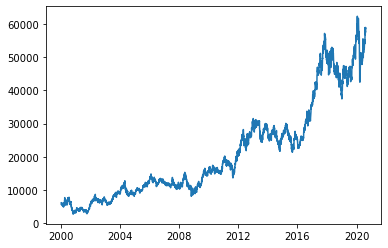

In [4]:
plt.plot(ts)

## STEP 2: 전처리 수행
- 결측치 처리
- 로그 변환

In [5]:
# 결측치 처리
ts[ts.isna()] # Time series 에서 결측치가 있는 부분만 Series로 출력

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [6]:
ts = ts.interpolate(method="time")
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- [결측값 보간](https://rfriend.tistory.com/tag/interpolate%28method=%27time%27%29)

In [7]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3: 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Std")
    plt.show(block=False)

In [9]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

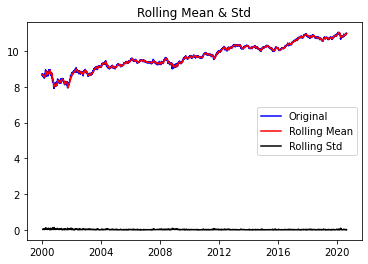

Results of Dickey-Fuller Test:
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

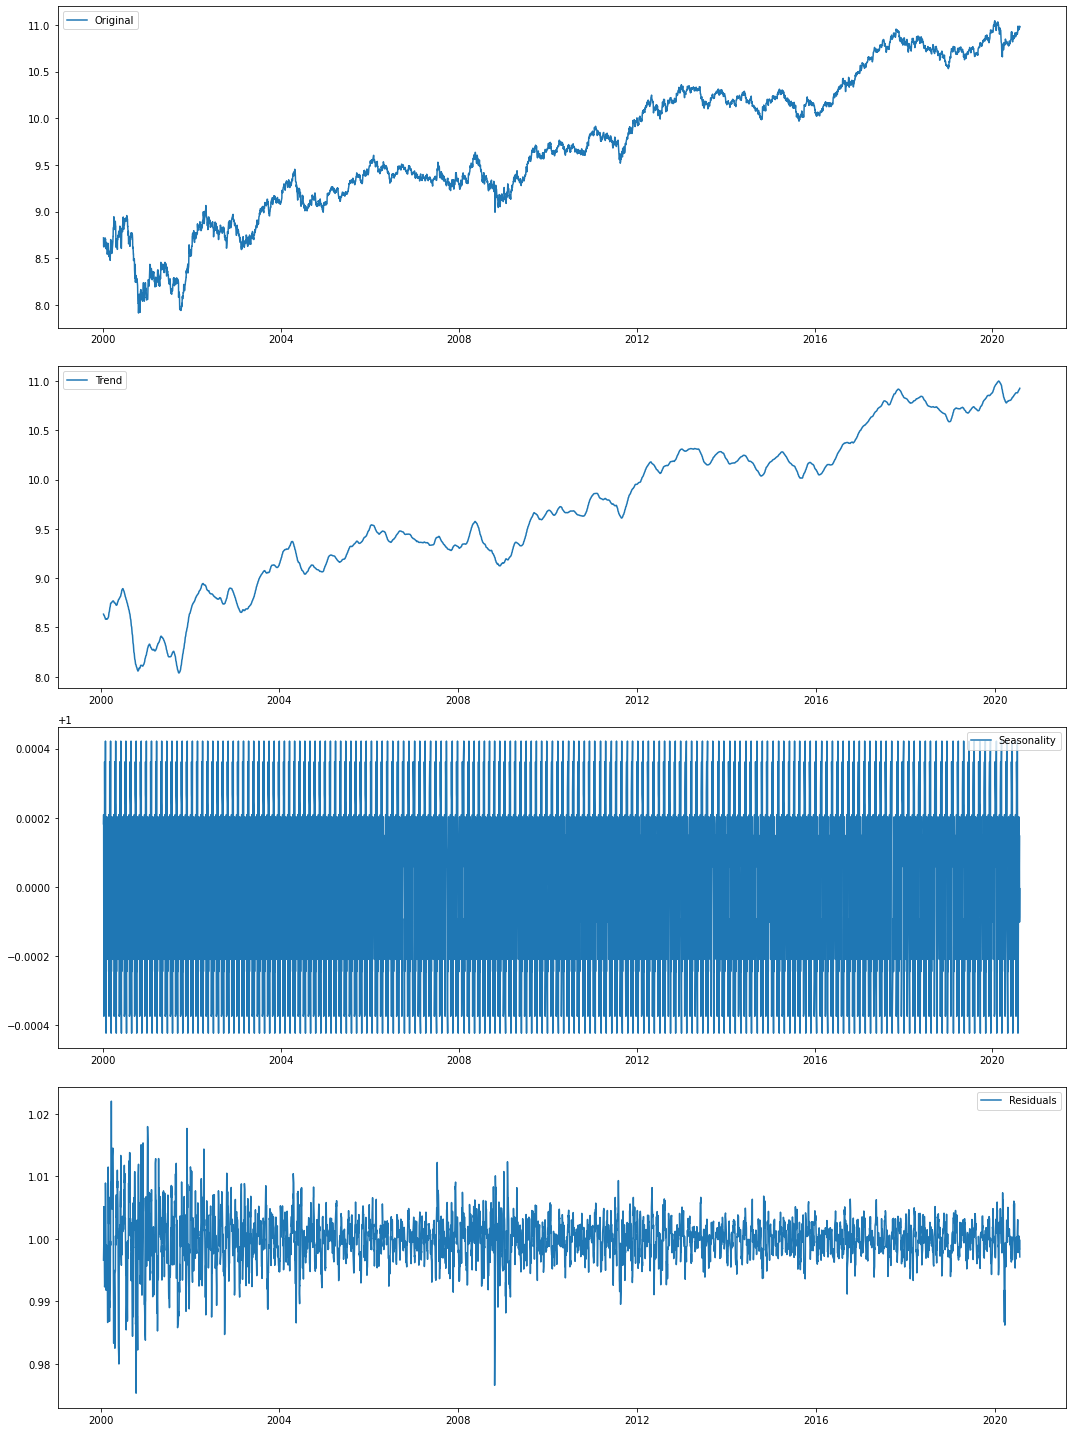

In [11]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,20


plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()

In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728531e+01
p-value                        5.748537e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

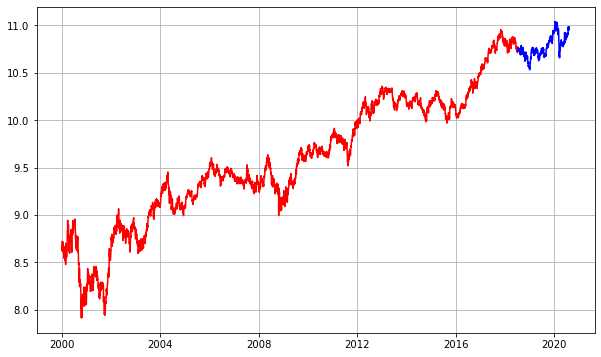

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c="r", label="training dataset")
plt.plot(test_data, c="b", label="test dataset")

## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

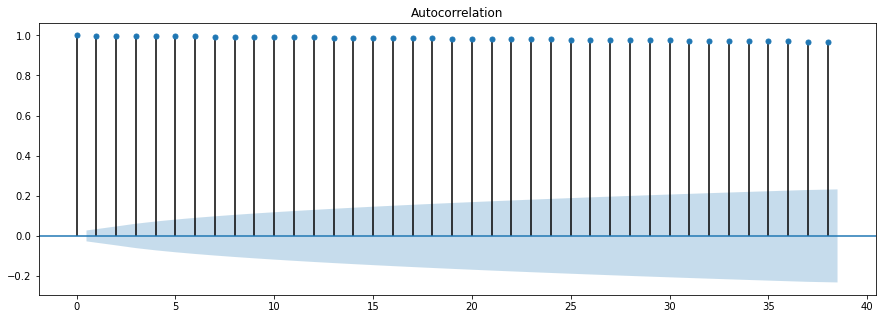

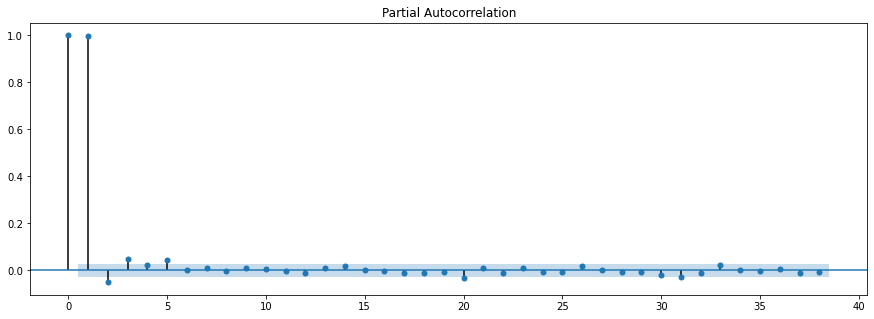

In [15]:
rcParams['figure.figsize'] = 15,5

# ACF, PACF 그려보기 -> p, q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


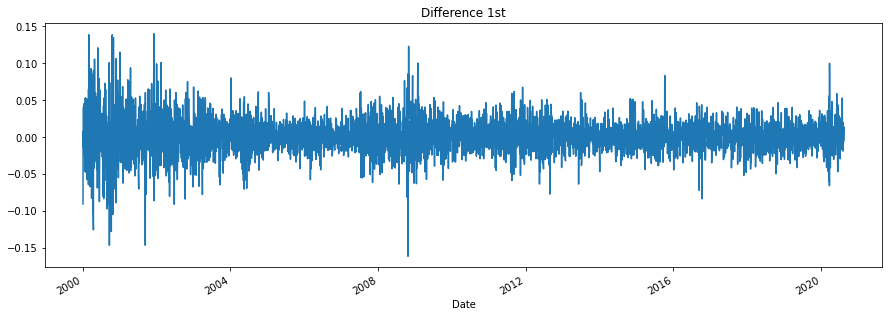

In [16]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.584636
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


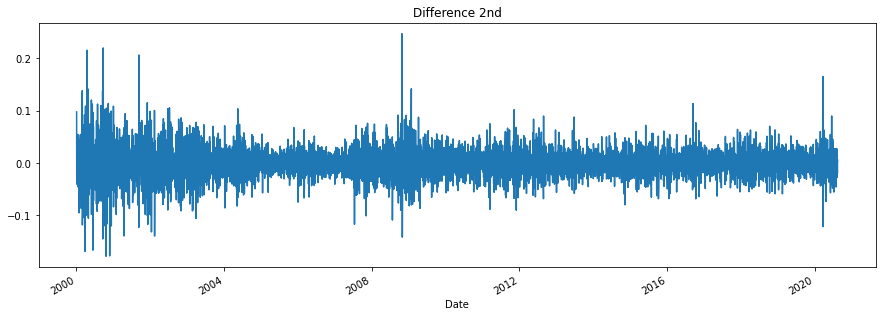

In [17]:
# 2차도 확인해보기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(1,1,0)) # p=1, d=1, q=0
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                         -21960.569
Time:                        11:11:19   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


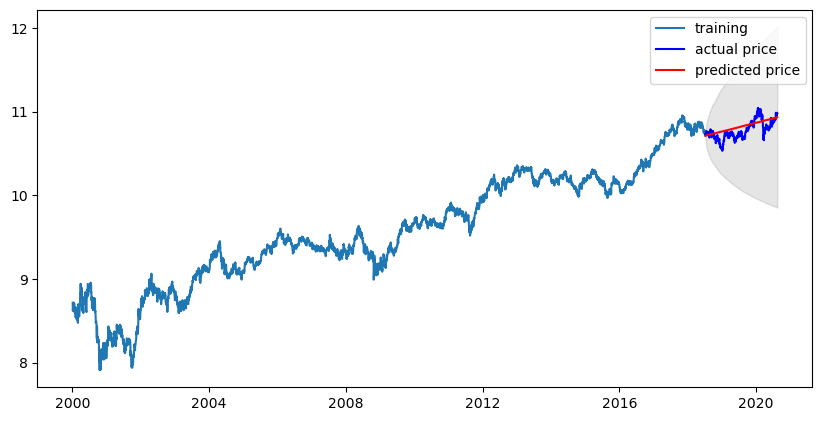

In [19]:
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.10)
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE:', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE:', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE:', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE: 18517858.63179965
MAE: 3590.190001880987
RMSE: 4303.238156528134
MAPE: 7.68%


## STEP 7 : 다른 주식 종목 예측해 보기

### LG 화학

In [42]:
# step 1. 시계열 데이터 준비
csv_path_2 = os.getenv("HOME") + ("/aiffel/stock_prediction/data/lgChem.csv")
df = pd.read_csv(csv_path_2, index_col="Date", parse_dates = True)
ts = df["Close"]
ts.head()

Date
2001-04-25    13000.0
2001-04-26    13000.0
2001-04-27    12700.0
2001-04-30    12800.0
2001-05-01        NaN
Name: Close, dtype: float64

In [43]:
# step 2. 전처리 수행
ts[ts.isna()]

Date
2001-05-01   NaN
2001-05-07   NaN
2001-06-06   NaN
2001-07-17   NaN
2001-08-15   NaN
2001-09-24   NaN
2001-09-28   NaN
2001-10-01   NaN
2001-10-02   NaN
2001-10-03   NaN
2001-11-09   NaN
2001-12-25   NaN
2001-12-31   NaN
2002-01-01   NaN
2002-01-03   NaN
2002-01-31   NaN
2002-02-11   NaN
2002-02-12   NaN
2002-02-13   NaN
2002-03-01   NaN
2002-04-05   NaN
2002-05-01   NaN
2002-06-06   NaN
2002-06-13   NaN
2002-07-01   NaN
2002-07-17   NaN
2002-08-15   NaN
2002-08-23   NaN
2002-09-20   NaN
2002-10-03   NaN
2002-12-02   NaN
2002-12-19   NaN
2002-12-25   NaN
2002-12-31   NaN
2003-01-01   NaN
2003-01-31   NaN
2003-05-01   NaN
2003-05-05   NaN
2003-05-08   NaN
2003-06-06   NaN
2003-07-17   NaN
2003-08-15   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [44]:
ts = ts.interpolate(methods = "time")
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

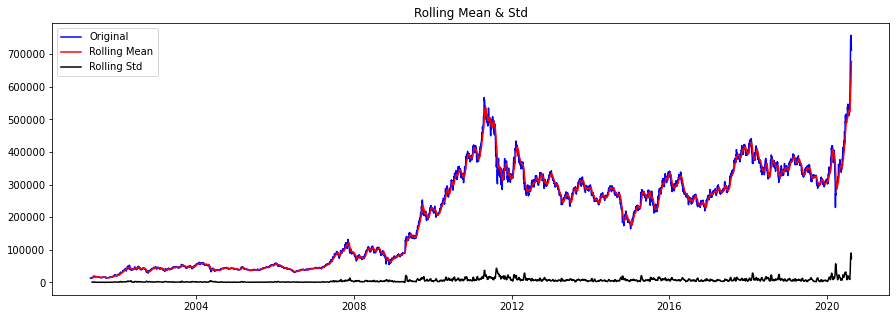

Results of Dickey-Fuller Test:
Test Statistic                    0.351796
p-value                           0.979600
#Lags Used                       25.000000
Number of Observations Used    4821.000000
Critical Value (1%)              -3.431707
Critical Value (5%)              -2.862140
Critical Value (10%)             -2.567089
dtype: float64


In [30]:
# step 3. 시계열 안정성 분석
## ts
plot_rolling_statistics(ts)
augmented_dickey_fuller_test(ts)

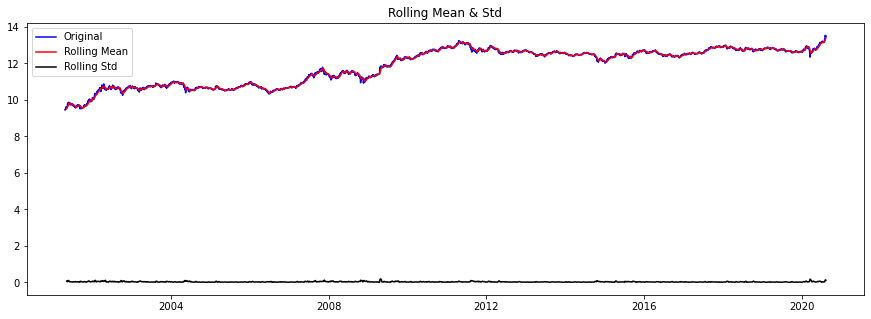

Results of Dickey-Fuller Test:
Test Statistic                   -1.538430
p-value                           0.514422
#Lags Used                        6.000000
Number of Observations Used    4840.000000
Critical Value (1%)              -3.431702
Critical Value (5%)              -2.862137
Critical Value (10%)             -2.567088
dtype: float64


In [48]:
## ts를 로그변환
ts_log = np.log(ts)
plot_rolling_statistics(ts_log)
augmented_dickey_fuller_test(ts_log)

In [49]:
## ts 로그변환 후, decomposition
decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)
trend =decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -19.772998
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    4792.000000
Critical Value (1%)              -3.431715
Critical Value (5%)              -2.862143
Critical Value (10%)             -2.567091
dtype: float64


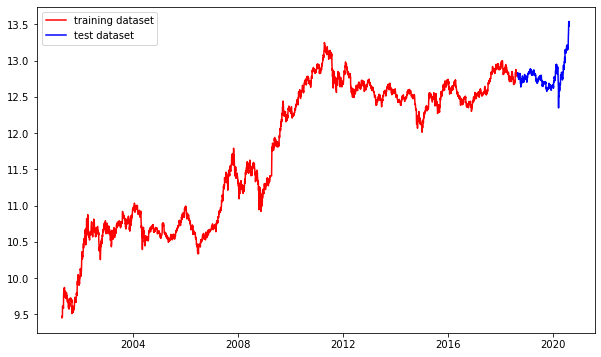

In [50]:
# step 4. 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.plot(train_data, color ="red", label="training dataset")
plt.plot(test_data, color ="blue", label="test dataset")
plt.legend()

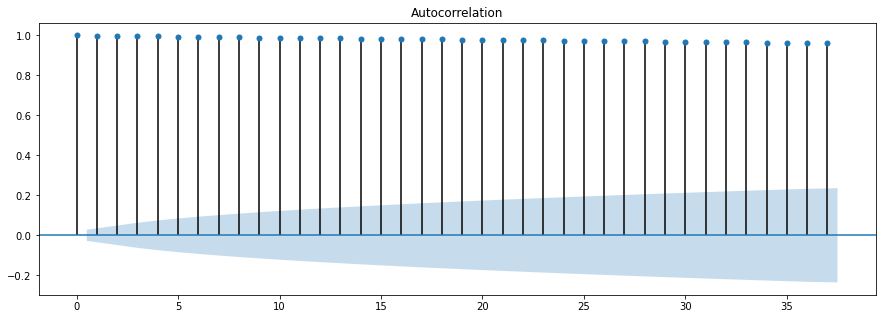

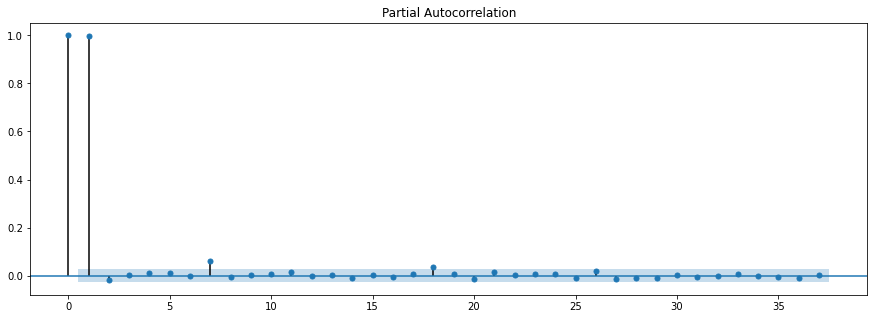

In [51]:
# Step 5. 적정 ARIMA 모수 찾기
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -30.815642
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4840.000000
Critical Value (1%)              -3.431702
Critical Value (5%)              -2.862137
Critical Value (10%)             -2.567088
dtype: float64


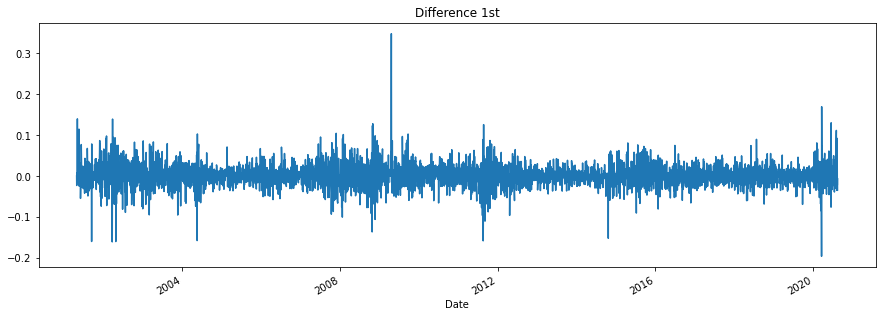

In [52]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")
augmented_dickey_fuller_test(diff_1)

In [53]:
# Step 6. ARIMA 모델 훈련과 테스트
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4361
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9571.926
Method:                       css-mle   S.D. of innovations              0.027
Date:                Fri, 14 Aug 2020   AIC                         -19137.853
Time:                        12:21:54   BIC                         -19118.711
Sample:                             1   HQIC                        -19131.097
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      1.820      0.069   -5.93e-05       0.002
ar.L1.D.Close     0.0346      0.015      2.288      0.022       0.005       0.064
                                    Root

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


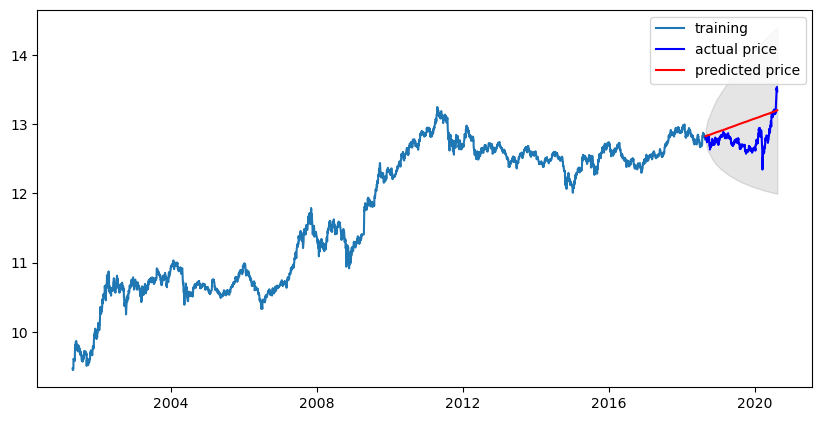

In [54]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=0.10)
plt.legend()
plt.show()

In [55]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape =np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12172637163.926289
MAE:  94001.01650548173
RMSE:  110329.67490175202
MAPE: 27.74%


### JYP Ent.

In [56]:
# Step1 : 시계열 데이터 준비
path = os.getenv("HOME") + ("/aiffel/stock_prediction/data/035900.KQ.csv")
df = pd.read_csv(path, index_col="Date", parse_dates = True)
ts = df["Close"]
ts.head()

Date
2001-08-31    2970000.0
2001-09-03    2617500.0
2001-09-04    2625000.0
2001-09-05    2940000.0
2001-09-06    3225000.0
Name: Close, dtype: float64

In [61]:
# Step2 : 각종 전처리 수행
ts = ts.interpolate(methods="time")
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

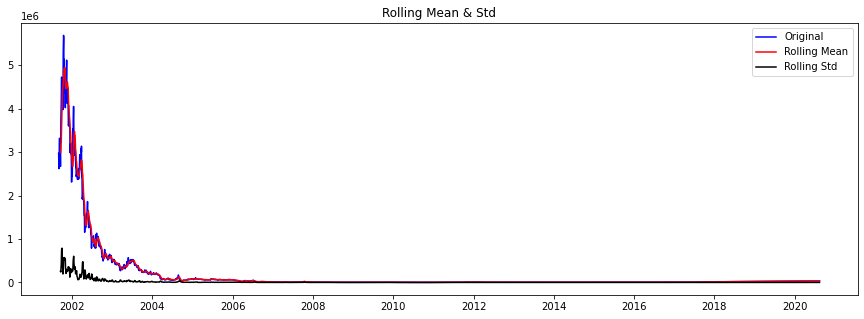

Results of Dickey-Fuller Test:
Test Statistic                -1.580045e+01
p-value                        1.075620e-28
#Lags Used                     3.200000e+01
Number of Observations Used    4.722000e+03
Critical Value (1%)           -3.431736e+00
Critical Value (5%)           -2.862152e+00
Critical Value (10%)          -2.567096e+00
dtype: float64


In [65]:
# Step3 : 시계열 안정성 분석
plot_rolling_statistics(ts)
augmented_dickey_fuller_test(ts)

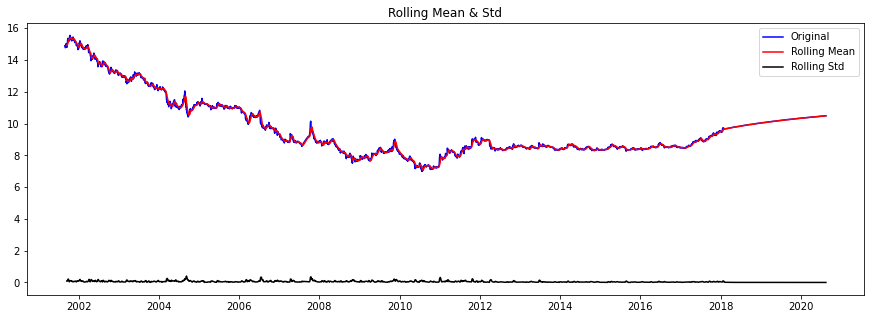

Results of Dickey-Fuller Test:
Test Statistic                   -3.605854
p-value                           0.005650
#Lags Used                       24.000000
Number of Observations Used    4730.000000
Critical Value (1%)              -3.431733
Critical Value (5%)              -2.862151
Critical Value (10%)             -2.567095
dtype: float64


In [67]:
ts_log = np.log(ts)
plot_rolling_statistics(ts_log)
augmented_dickey_fuller_test(ts_log)

In [72]:
decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [75]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.818554e+01
p-value                        2.426759e-30
#Lags Used                     3.200000e+01
Number of Observations Used    4.692000e+03
Critical Value (1%)           -3.431744e+00
Critical Value (5%)           -2.862156e+00
Critical Value (10%)          -2.567098e+00
dtype: float64


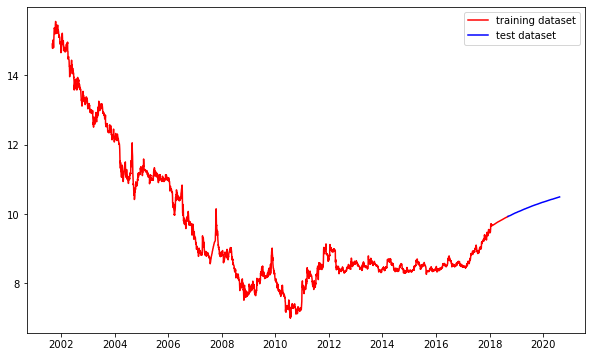

In [76]:
# Step4 : 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.plot(train_data, color="red", label="training dataset")
plt.plot(test_data, color="blue", label="test dataset")
plt.legend()

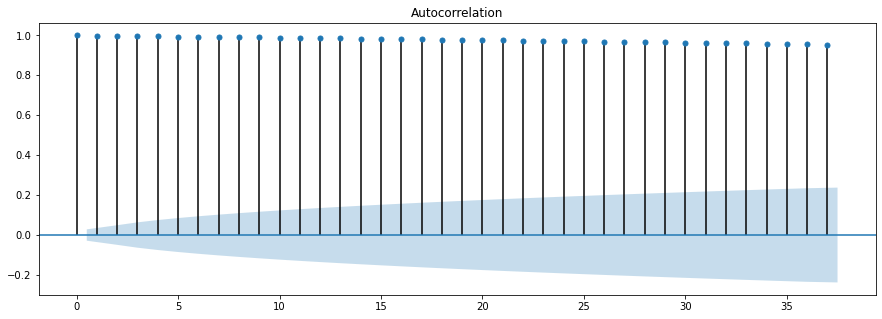

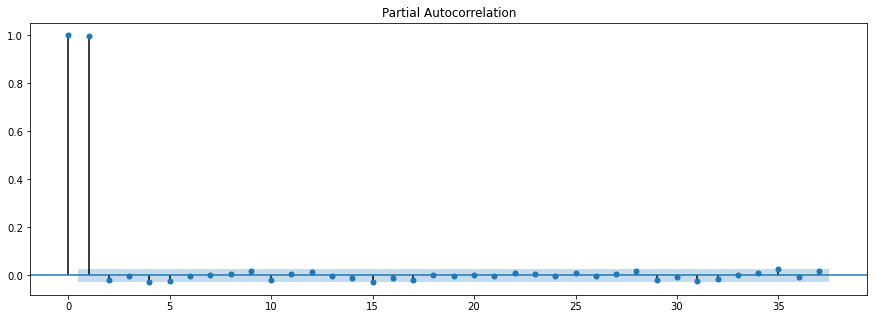

Results of Dickey-Fuller Test:
Test Statistic                -1.514103e+01
p-value                        7.010442e-28
#Lags Used                     2.300000e+01
Number of Observations Used    4.730000e+03
Critical Value (1%)           -3.431733e+00
Critical Value (5%)           -2.862151e+00
Critical Value (10%)          -2.567095e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.659167
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    4722.000000
Critical Value (1%)              -3.431736
Critical Value (5%)              -2.862152
Critical Value (10%)             -2.567096
dtype: float64


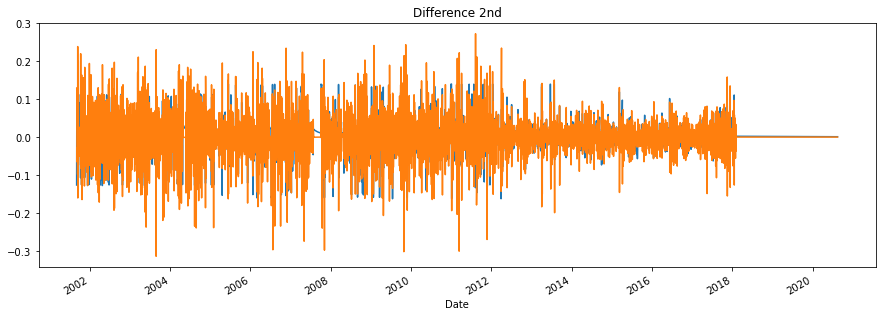

In [78]:
# Step5 : 적정 ARIMA 모수 찾기
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")
augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")
augmented_dickey_fuller_test(diff_2)

In [79]:
# Step6 : ARIMA 모델 훈련과 테스트
model = ARIMA(train_data, order= (1,1,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4278
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7252.489
Method:                       css-mle   S.D. of innovations              0.044
Date:                Fri, 14 Aug 2020   AIC                         -14498.979
Time:                        13:57:24   BIC                         -14479.895
Sample:                             1   HQIC                        -14492.237
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0012      0.001     -1.484      0.138      -0.003       0.000
ar.L1.D.Close     0.1373      0.015      9.056      0.000       0.108       0.167
                                    Root

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


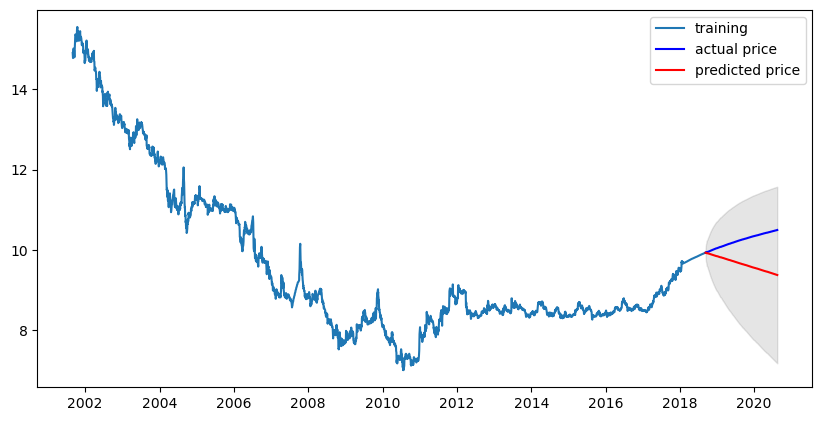

In [80]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=0.10)
plt.legend()
plt.show()

In [81]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape =np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  207775779.7378888
MAE:  12591.919707083534
RMSE:  14414.429566857261
MAPE: 41.50%


### 모델 성능 개선
- 과거에 지속적으로 폭락했던 것과 달리, 최근에는 몇 년 간 상승해서 모델 성능이 안좋은 듯 
- 과거 데이터 삭제

In [158]:
path = os.getenv("HOME") + ("/aiffel/stock_prediction/data/035900.KQ.csv")
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-08-31,2970000.0,2970000.0,2970000.0,2970000.0,2970000.0,150.0
1,2001-09-03,2617500.0,2617500.0,2617500.0,2617500.0,2617500.0,73.0
2,2001-09-04,2370000.0,2842500.0,2370000.0,2625000.0,2625000.0,4151.0
3,2001-09-05,2625000.0,2940000.0,2550000.0,2940000.0,2940000.0,2591.0
4,2001-09-06,2992500.0,3285000.0,2970000.0,3225000.0,3225000.0,2274.0


In [159]:
for i in range(20*12*10):
    df = df.drop(i)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2400,2011-01-24,2445.0,2530.0,2410.0,2440.0,2440.0,590060.0
2401,2011-01-25,2460.0,2535.0,2365.0,2365.0,2365.0,836864.0
2402,2011-01-26,2355.0,2355.0,2165.0,2220.0,2220.0,1313705.0
2403,2011-01-27,2270.0,2335.0,2220.0,2285.0,2285.0,778065.0
2404,2011-01-28,2300.0,2450.0,2235.0,2300.0,2300.0,1214942.0


In [160]:
df.Date = pd.to_datetime(df.Date)
df['Date'].head()

2400   2011-01-24
2401   2011-01-25
2402   2011-01-26
2403   2011-01-27
2404   2011-01-28
Name: Date, dtype: datetime64[ns]

In [162]:
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-24,2445.0,2530.0,2410.0,2440.0,2440.0,590060.0
2011-01-25,2460.0,2535.0,2365.0,2365.0,2365.0,836864.0
2011-01-26,2355.0,2355.0,2165.0,2220.0,2220.0,1313705.0
2011-01-27,2270.0,2335.0,2220.0,2285.0,2285.0,778065.0
2011-01-28,2300.0,2450.0,2235.0,2300.0,2300.0,1214942.0


In [163]:
ts = df["Close"]
ts.head()

Date
2011-01-24    2440.0
2011-01-25    2365.0
2011-01-26    2220.0
2011-01-27    2285.0
2011-01-28    2300.0
Name: Close, dtype: float64

In [164]:
ts = ts.interpolate(method="time")
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

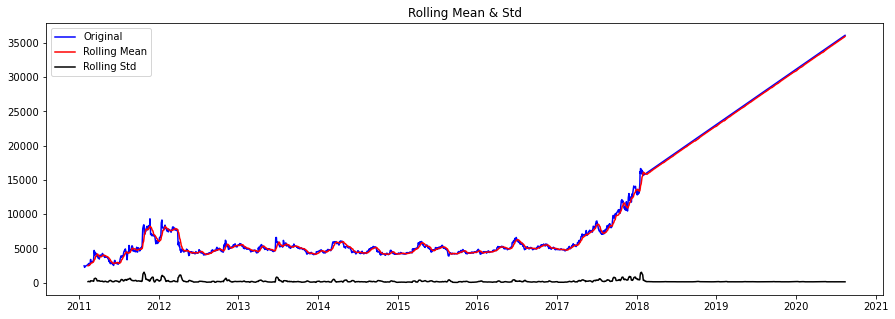

Results of Dickey-Fuller Test:
Test Statistic                    2.611117
p-value                           0.999077
#Lags Used                       23.000000
Number of Observations Used    2331.000000
Critical Value (1%)              -3.433158
Critical Value (5%)              -2.862781
Critical Value (10%)             -2.567430
dtype: float64


In [165]:
plot_rolling_statistics(ts)
augmented_dickey_fuller_test(ts)

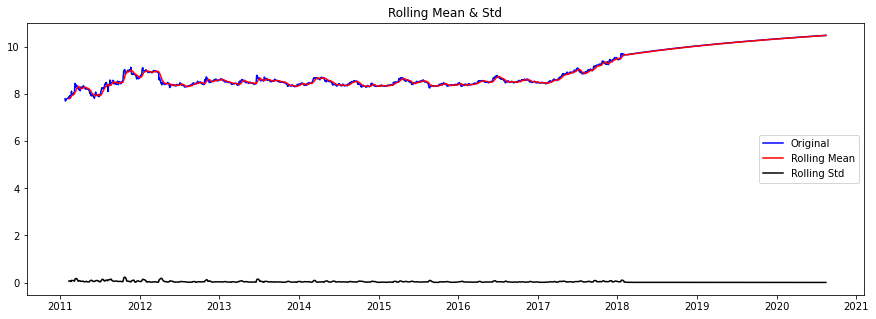

Results of Dickey-Fuller Test:
Test Statistic                   -0.541360
p-value                           0.883690
#Lags Used                        1.000000
Number of Observations Used    2353.000000
Critical Value (1%)              -3.433132
Critical Value (5%)              -2.862769
Critical Value (10%)             -2.567424
dtype: float64


In [166]:
ts_log = np.log(ts)
plot_rolling_statistics(ts_log)
augmented_dickey_fuller_test(ts_log)

In [169]:
## ts 로그변환 후, decomposition
decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)
trend =decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [170]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.267355e+01
p-value                        1.229649e-23
#Lags Used                     2.600000e+01
Number of Observations Used    2.298000e+03
Critical Value (1%)           -3.433199e+00
Critical Value (5%)           -2.862799e+00
Critical Value (10%)          -2.567440e+00
dtype: float64


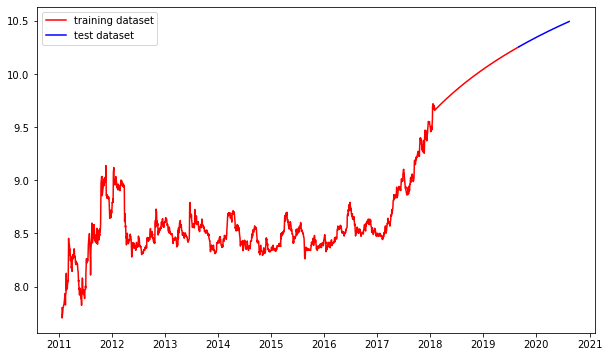

In [168]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.plot(train_data, color ="red", label="training dataset")
plt.plot(test_data, color ="blue", label="test dataset")
plt.legend()

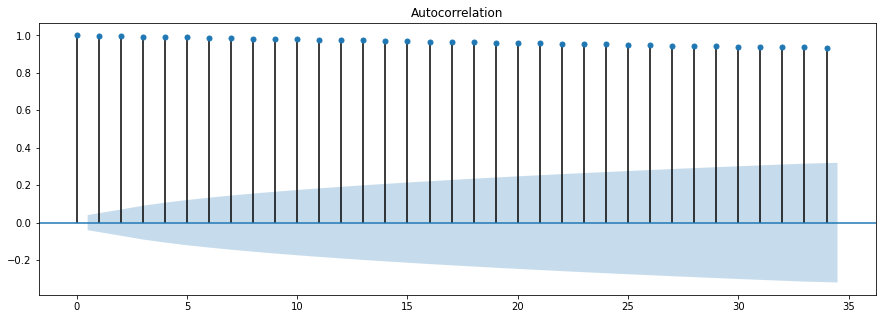

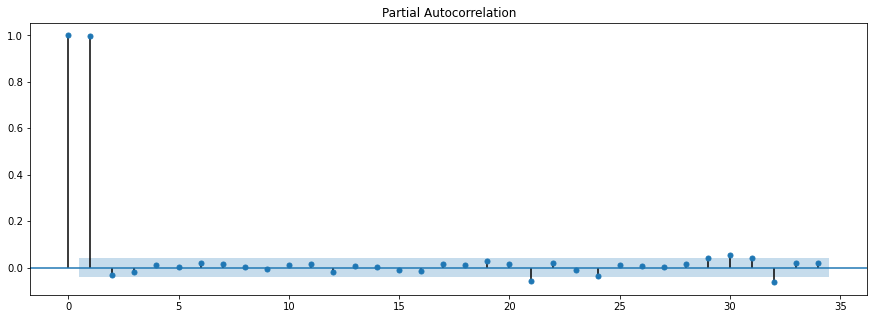

Results of Dickey-Fuller Test:
Test Statistic                  -45.830779
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2353.000000
Critical Value (1%)              -3.433132
Critical Value (5%)              -2.862769
Critical Value (10%)             -2.567424
dtype: float64


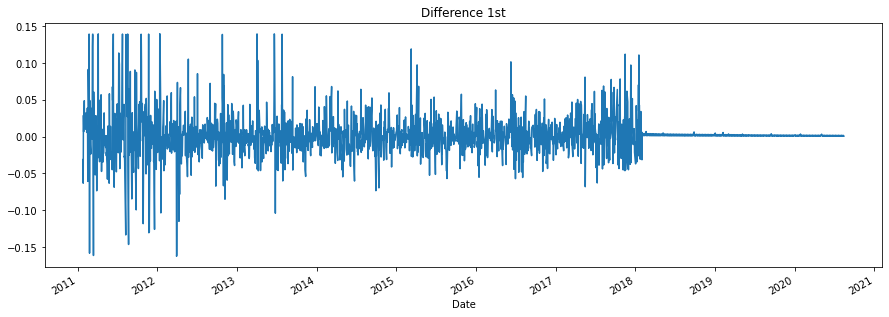

In [171]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")
augmented_dickey_fuller_test(diff_1)

In [172]:
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2118
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4507.635
Method:                       css-mle   S.D. of innovations              0.029
Date:                Fri, 14 Aug 2020   AIC                          -9009.270
Time:                        14:46:27   BIC                          -8992.295
Sample:                             1   HQIC                         -9003.055
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.746      0.081      -0.000       0.002
ar.L1.D.Close     0.0566      0.022      2.609      0.009       0.014       0.099
                                    Root

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


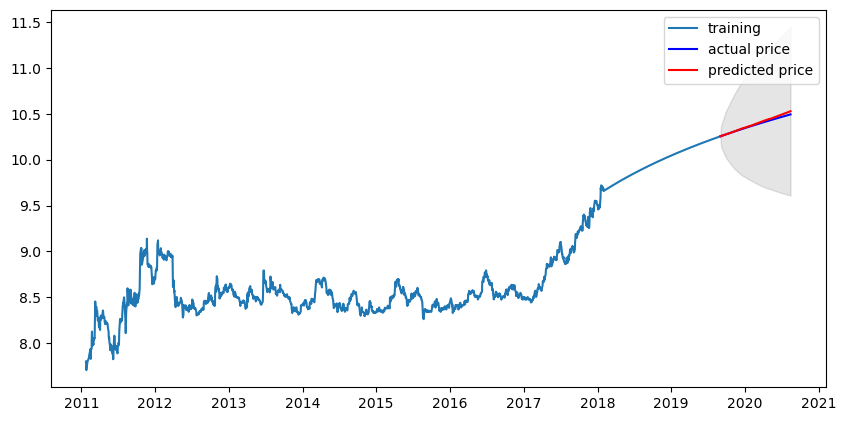

In [173]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=0.10)
plt.legend()
plt.show()


In [174]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape =np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  287264.6768067321
MAE:  392.9928156524524
RMSE:  535.9707798068213
MAPE: 1.15%
